<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [55]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")  #  not included in the zip
captions = json.load(open('data/captions_tokenized.json'))  #  not included in the zip

CPU times: user 655 ms, sys: 1.78 s, total: 2.43 s
Wall time: 3.28 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [56]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [57]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [58]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
import itertools
merged_captions = list(itertools.chain(*captions))
merged_captions = list(itertools.chain(*merged_captions))

word_counts = Counter(merged_captions)

In [59]:
word_counts.most_common(5)

[('a', 978125),
 ('#START#', 591435),
 ('#END#', 591435),
 ('.', 444651),
 ('on', 215537)]

In [60]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [61]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [62]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [63]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [64]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [65]:
network = CaptionNet(n_tokens)

In [66]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [67]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits_for_next.view(-1, 10403), captions_ix_next.view(-1))
    
    return loss

In [68]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

# assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()


assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [69]:
optimizer = torch.optim.Adam(params=network.parameters(), lr=0.001)

# Training

* First implement the batch generator
* Than train the network as usual

In [70]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [71]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [72]:
generate_batch(img_codes,captions,3)

(tensor([[0.1559, 0.2391, 0.7991,  ..., 0.4696, 0.6442, 0.0292],
         [0.1192, 0.3422, 0.2536,  ..., 0.0033, 0.4642, 0.4010],
         [1.0567, 0.1419, 0.1206,  ..., 0.4034, 0.2734, 0.8702]]),
 tensor([[   1,  652,    4,  324,   35,    7,  458,   35,   24,  103,   12,    2,
             3],
         [   1,   46,   15,   47,  398,   53,  503,   14,    7,  246,  162,   12,
             2],
         [   1,   24,  197,  900,  140,    6,   24, 4100,  184,   12,    2,    3,
             3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [73]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [119]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 1.567575968503952, val loss: 1.4351680994033813


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 1.4994834399223327, val loss: 1.4321183800697326


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 1.6450999450683594, val loss: 1.5874218940734863


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 1.516227079629898, val loss: 1.3951895236968994


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 1.580412085056305, val loss: 1.64786696434021


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 1.55850248336792, val loss: 1.563720417022705


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 1.5346085596084595, val loss: 1.7933645248413086


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 1.5958836579322815, val loss: 1.5980807304382325


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 1.5310250282287599, val loss: 1.528682017326355


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 1.5007410645484924, val loss: 1.5622455596923828


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 1.5434630882740021, val loss: 1.6311870574951173


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 1.5233921802043915, val loss: 1.567403292655945


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 1.5403121757507323, val loss: 1.5812017917633057


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 1.5176709008216858, val loss: 1.7120303153991698


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 1.5679279458522797, val loss: 1.6042363882064818


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 1.5285132801532746, val loss: 1.3425435066223144


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 1.5563814544677734, val loss: 1.5118528723716735


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 1.5439317393302918, val loss: 1.6713826656341553


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 1.5563807725906371, val loss: 1.4435013771057128


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 1.5886639595031737, val loss: 1.5853971481323241


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 1.4987412321567535, val loss: 1.3131159782409667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 1.4807582569122315, val loss: 1.6663925886154174


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 1.4697258245944977, val loss: 1.5281152725219727


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 1.5733362686634065, val loss: 1.4971164107322692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 1.495440249443054, val loss: 1.6924174070358275


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 1.4927666783332825, val loss: 1.4691119551658631


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 1.5578077375888824, val loss: 1.4170120120048524


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 1.5317978632450104, val loss: 1.554880928993225


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 1.5307544517517089, val loss: 1.5689097404479981


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 1.5744102644920348, val loss: 1.5841479778289795


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 1.511290808916092, val loss: 1.5357253789901733


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 1.4906912875175475, val loss: 1.6002814054489136


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 1.4787668895721435, val loss: 1.3328921794891357


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 1.5226778411865234, val loss: 1.2837252140045166


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 1.5366844499111176, val loss: 1.744570016860962


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 1.427075721025467, val loss: 1.4563024282455443


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 1.5883905494213104, val loss: 1.3679460287094116


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 1.519125121831894, val loss: 1.3220961093902588


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 1.4940035295486451, val loss: 1.5972454786300658


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 1.519583841562271, val loss: 1.584706711769104


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 1.4576699554920196, val loss: 1.5103692531585693


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 1.555721983909607, val loss: 1.5937593936920167


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 1.5030219650268555, val loss: 1.5102058172225952


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 1.503987592458725, val loss: 1.5400962114334107


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 1.5294933676719666, val loss: 1.6248074293136596


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 1.5378846406936646, val loss: 1.4453323364257813


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 1.4809018409252166, val loss: 1.5447622060775756


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 1.4178227400779724, val loss: 1.7808241605758668


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 1.5069715511798858, val loss: 1.516714382171631


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 1.519430649280548, val loss: 1.63912353515625


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 1.4969239103794099, val loss: 1.633634877204895


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 1.4709163081645966, val loss: 1.6290829658508301


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 1.4963459730148316, val loss: 1.5860761642456054


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 1.5461551332473755, val loss: 1.5477972269058227


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 1.4611961328983307, val loss: 1.564526128768921


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 1.477934225797653, val loss: 1.535987663269043


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 1.433249009847641, val loss: 1.6204725980758667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 1.48652836561203, val loss: 1.4785647869110108


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 1.4723442327976226, val loss: 1.5468700170516967


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 1.5000683426856996, val loss: 1.5815905570983886


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 1.5504155123233796, val loss: 1.43178071975708


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 1.49064532995224, val loss: 1.6183608293533325


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 1.533985377550125, val loss: 1.7050103425979615


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 1.5368500638008118, val loss: 1.6576995849609375


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 1.467591518163681, val loss: 1.7007615089416503


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 1.5163741409778595, val loss: 1.5931168079376221


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 1.5360234212875366, val loss: 1.4637733936309814


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 1.4927803766727448, val loss: 1.4460515260696412


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 1.3969002616405488, val loss: 1.63526394367218


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 1.474029256105423, val loss: 1.451550579071045


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 1.4774599254131318, val loss: 1.455267596244812


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 1.4951765537261963, val loss: 1.6266471862792968


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 1.459893946647644, val loss: 1.4376317262649536


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 1.4554143178462982, val loss: 1.461494469642639


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 1.4964480936527251, val loss: 1.4513596177101136


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 1.5226028180122375, val loss: 1.4385857105255127


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 1.458280987739563, val loss: 1.6085763931274415


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 1.4729691994190217, val loss: 1.4784621477127076


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 1.4326229321956634, val loss: 1.4481327414512635


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 1.4545662677288056, val loss: 1.5687920093536376


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 1.4954172015190124, val loss: 1.6431688070297241


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 1.5082980859279633, val loss: 1.189288580417633


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 1.4102556908130646, val loss: 1.5833928108215332


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 1.5014670550823213, val loss: 1.4857619762420655


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 1.4788604247570039, val loss: 1.4945072412490845


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 1.4755769443511964, val loss: 1.5769739389419555


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 1.5348967838287353, val loss: 1.5178792238235475


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 1.429580614566803, val loss: 1.4888428926467896


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 1.5312903475761415, val loss: 1.5374450922012328


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 1.499749504327774, val loss: 1.363726544380188


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 1.4456481385231017, val loss: 1.5809016704559327


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 1.4362476074695587, val loss: 1.5932542324066161


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 1.4444444179534912, val loss: 1.5439465761184692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 1.4445160412788391, val loss: 1.5573386192321776


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 1.436243839263916, val loss: 1.4410614609718322


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 1.4264796900749206, val loss: 1.329161822795868


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 1.4809734404087067, val loss: 1.4437822103500366


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 1.4250455236434936, val loss: 1.544315552711487


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 1.5793336522579193, val loss: 1.3943343997001647


100%|██████████| 50/50 [00:24<00:00,  2.27it/s]



Epoch: 99, train loss: 1.5063035571575165, val loss: 1.4178850889205932
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [75]:
# state_dict = torch.load('Network_hw4_pt2.pth')
# network.load_state_dict(state_dict)

In [120]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [121]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [122]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
# !wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


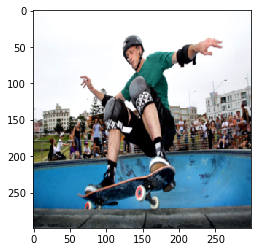

In [123]:
plt.imshow(img)

In [124]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a ramp .
a man on a skateboard doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man jumping up on a skateboard in a skate park .
a man doing a trick on a skateboard in a park .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


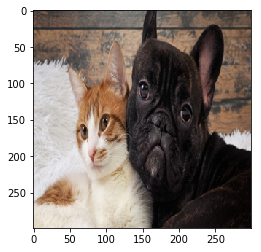

a cat is sitting on a chair in front of a building .
a cat is standing on a chair in front of a building .
a cat sitting on a couch with a remote control .
a cat sitting in a green chair next to a window .
a cat is sitting on a chair in a room .
a cat is sitting in a chair next to a cat .
a black and white cat sitting on a couch .
a cat is standing on the ground next to a cat .
a black and white cat is sitting on a bed .
a cat is laying down in a black chair .


In [125]:
# !wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img1.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


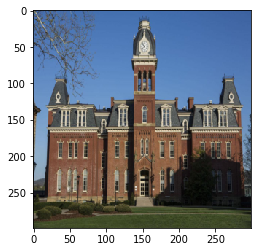

a large building with a clock on the top .
a large building with a clock tower on the side of it .
a large building with a clock on it .
a large clock tower with a clock on the top .
a large building with a clock tower on it .
a large building with a clock tower on it .
a large building with a clock on the top .
a large building with a clock tower on it .
a large building with a clock tower on it .
a large building with a clock tower on the side of it .


In [126]:
# apply your network on images you've found
img = plt.imread('data/img1-1.jpg')  #  successful
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


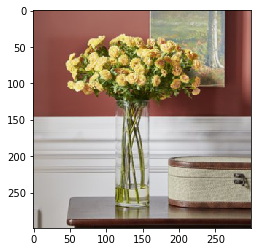

a vase with flowers on it and a glass of water .
a vase with flowers in it on a table
a vase of flowers sitting on a table .
a vase with a flower in it on a table
a vase with flowers in it on a table
a vase with a flower on top of it .
a vase with a flower pot on it
a vase with flowers in it and a vase with a flower on it .
a vase with a vase of flowers on it
a vase with a flower pot on it


In [127]:
img = plt.imread('data/img2.jpg')  #  successful
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


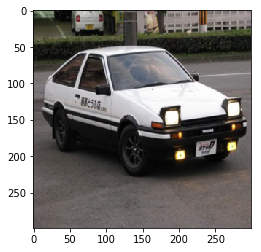

a car parked in a parking lot with a dog on it .
a car parked on a street next to a building .
a car parked on a street next to a building .
a car parked on a street with a dog on it .
a car parked on a street next to a building .
a car parked on the side of a street .
a car parked on a street next to a building .
a car parked in a parking lot with a dog on it .
a car parked in a parking lot with a dog on it .
a car parked on a street next to a building .


In [83]:
img = plt.imread('data/img3.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


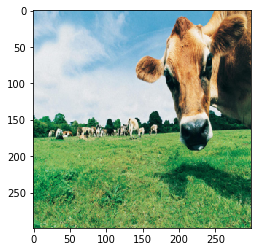

a cow is standing in a field with a dog .
a brown and white horse standing in a field .
a cow is standing in a field with a cow .
a cow is standing in a field with a dog .
a horse standing on a field with a big green sky .
a brown and white horse standing next to a fence .
a brown and white cow standing in a field .
a brown horse standing in a field with a green grass .
a horse is standing in a field with a dog .
a brown and white horse standing next to a fence .


In [100]:
img = plt.imread('data/img5.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


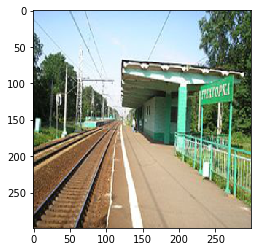

a train on a track near a building .
a train on a track near a building .
a train traveling down a track in a lot .
a train traveling down tracks near a bridge .
a train on a track near a building
a train on a track near a building .
a train that is on a track in a parking lot .
a train that is on a track in a city .
a train is on the tracks near a bridge .
a train traveling down tracks next to a bridge .


In [86]:
img = plt.imread('data/img6.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


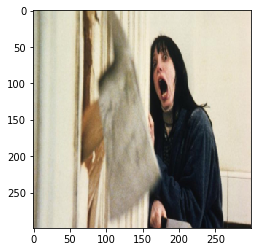

a woman with a hat and her hair .
a woman in a dress and a hat
a woman in a dress and a woman standing in a room .
a woman in a dress holding a cell phone .
a woman in a dress and black dress holding a cell phone .
a woman in a dress holding a cell phone .
a woman holding a cell phone in her hand .
a woman in a dress and a woman standing next to a woman .
a woman holding a cell phone in a room .
a woman in a dress and a hat and her hair


In [102]:
img = plt.imread('data/img4.jpg')  # so so
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


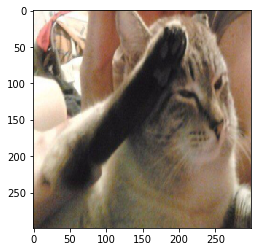

a cat is laying on a bed with a cat .
a cat is laying down on a bed .
a cat is laying on a bed in a room .
a cat laying on a bed with a cat .
a cat is laying on a bed with a cat .
a cat is laying on a bed with a cat .
a cat is laying down on a bed .
a cat is laying on a bed with a cat .
a cat laying on a bed with a cat in it .
a cat is laying down in a black bag .


In [87]:
img = plt.imread('data/img10.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


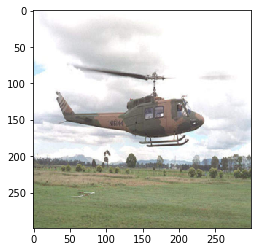

a large airplane is parked on a runway .
a large airplane is parked on a runway .
a plane that is parked in the air .
a plane that is parked on a runway .
a plane that is parked on the runway .
a plane sitting on a runway next to a blue sky .
a plane flying through the air over a cloudy sky .
a plane that is parked on a runway .
a plane flying through the air while flying in the sky .
a plane flying in the sky on a cloudy day .


In [112]:
img = plt.imread('data/img9.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


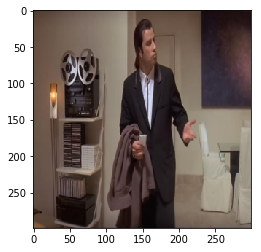

a man standing in a room with a phone .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing next to a fire hydrant .
a man in a suit and tie standing on a train .
a man in a suit and tie standing in a room .
a man in a suit and tie standing in a room .
a man standing in a room with a cell phone .
a man in a suit and tie standing in a room .


In [128]:
img = plt.imread('data/img8.jpg')  # successful
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


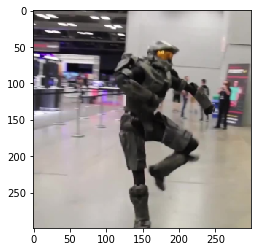

a man riding a skateboard down a ramp .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man on a skateboard doing tricks on a skateboard .
a man riding a skateboard down a street .
a man riding a skateboard down a sidewalk .
a man riding a skateboard down a ramp .
a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a skateboard down a street .


In [107]:
img = plt.imread('data/img7.jpg')  #  failed
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


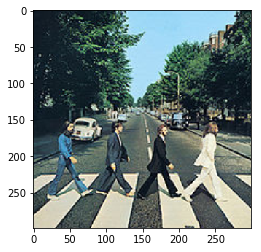

a group of people walking down a street .
a group of people standing on a bench in the grass .
a group of people standing on a bench with a kite .
a group of people standing around a park bench .
a group of people walking down a street .
a group of people on a skateboard on a sidewalk .
a group of people on a bench in a field .
a group of people walking down a street .
a group of people on a bench in the rain .
a man is walking down a road with a kite .


In [118]:
img = plt.imread('data/img12.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


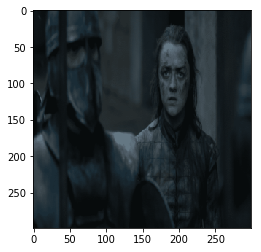

a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in a kitchen .
a man in a suit and tie standing in front of a building .
a man with a beard and a vase with a cat on it .
a man in a suit and tie standing in front of a building .
a man with a beard and a black and white photo of a woman


In [130]:
img = plt.imread('data/img13.jpg')  #  so so
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


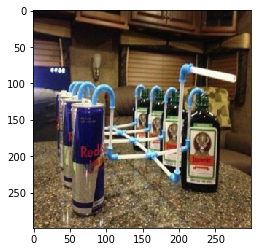

a group of suitcases are sitting on a wooden bench .
a wooden table with a bunch of luggage on it
a bunch of suitcases on a wooden table .
a bunch of suitcases sitting on a wooden floor .
a group of people standing around a wooden bench .
a group of suitcases are sitting in a parking lot .
a couple of suitcases sitting on a wooden bench .
a group of suitcases are sitting on a wooden bench .
a wooden table with a bunch of suitcases on it .
a wooden table with a bunch of luggage on it .


In [131]:
img = plt.imread('data/img14.jpg')  #  ok
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)